<a href="https://colab.research.google.com/github/pelka-izabella/miscellaneous/blob/main/Pelka_Izabella.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Izabella Pełka

Assignment:

The NG technical test for data science interview consists in building an end to end ML pipeline that takes a raw dataset Dataset.csv (joined), containing a commodity price values from 3 different markets, and forecasts the open to open price movement direction for market 2, for the next day, based on the data.



It is a binary classification problem. The models performances will be assessed over the last 50 days (validation set), given a metric defined by the candidate. The choice of the model is up to the candidate.


The results will be returned in a jupyter notebook (.ipynb file) with cells that have the results saved in, that will be discussed together.


No need to use exterior data. 



In [519]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from collections import Counter

from scipy.stats import pointbiserialr

In [520]:
from sklearn.linear_model import LogisticRegression

# Data preparation

In [521]:
df_raw = pd.read_csv('Dataset.csv')

In [522]:
df_raw.head()

,DateTime,Market1: Close,Market1: High,Market1: Low,Market1: Open,Market2: Close,Market2: High,Market2: Low,Market2: Open,Market2: Open_Interest,Market2: Volume,Market3: Close,Market3: High,Market3: Low,Market3: Open,Market3: Open_Interest,Market3: Volume
0,2015-01-05T00:00:00.000,276.60,282.70,274.40,281.40,6145.0,6275.5,6095.50,6255.0,301759.0,78077.0,45250.0,45570.0,44990.0,45500.0,704092.0,189194.0
1,2015-01-06T00:00:00.000,276.70,278.20,275.65,276.95,6145.0,6178.0,6114.00,6150.0,299683.0,50088.0,44570.0,44910.0,43980.0,44210.0,698540.0,447986.0
2,2015-01-07T00:00:00.000,275.85,277.65,274.80,276.00,6115.0,6151.5,6091.50,6130.0,297582.0,53173.0,44660.0,44840.0,44420.0,44640.0,700286.0,317816.0
3,2015-01-08T00:00:00.000,276.95,279.40,275.35,276.40,6104.0,6189.0,6103.85,6126.5,300723.0,55424.0,44740.0,44890.0,44580.0,44650.0,695008.0,208524.0
4,2015-01-09T00:00:00.000,275.45,277.60,273.85,276.70,6090.0,6148.5,6073.50,6132.0,303841.0,48765.0,44550.0,45050.0,44250.0,45000.0,725376.0,384066.0


In [523]:
# lowercasing column names and replacing ": " with underscore for convenience
df_raw.columns = df_raw.columns.str.lower()
df_raw.columns = df_raw.columns.str.replace(": ", "_")

In [524]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1607 entries, 0 to 1606
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   datetime               1607 non-null   object 
 1   market1_close          1555 non-null   float64
 2   market1_high           1555 non-null   float64
 3   market1_low            1555 non-null   float64
 4   market1_open           1555 non-null   float64
 5   market2_close          1563 non-null   float64
 6   market2_high           1563 non-null   float64
 7   market2_low            1563 non-null   float64
 8   market2_open           1563 non-null   float64
 9   market2_open_interest  1548 non-null   float64
 10  market2_volume         1563 non-null   float64
 11  market3_close          1503 non-null   float64
 12  market3_high           1503 non-null   float64
 13  market3_low            1503 non-null   float64
 14  market3_open           1502 non-null   float64
 15  mark

In [525]:
# assigning a correct type
df_raw['datetime'] = df_raw['datetime'].astype('datetime64[ns]')

In [526]:
df_raw['datetime'].min()

Timestamp('2015-01-05 00:00:00')

In [527]:
df_raw['datetime'].max()

Timestamp('2021-03-08 00:00:00')

In [528]:
df_raw.fillna(method='ffill', inplace=True)

The file contains daily data of close, high, low and open prices prices for 3 markets, as well as open interest values for Markets 2&3, and volume for Market 3. The time scope of the study is between 5th of January 2015 and 8th of March 2021. 

The DateTime column was turned into a datetime type, the other columns had already been correctly identified as float types.

There were missing values in the numerical columns and I decided to fill them using a forward fill, assuming that if the price is missing for a certain day, last known piece of information is still valid. 



In [529]:
# label preparation
df_raw['open2_diff'] = df_raw['market2_open'].diff(1)
label = np.where(df_raw['open2_diff']>0, 1, 0)
df_raw.drop('open2_diff', axis=1, inplace=True)

In [530]:
# since we want to predict movement for the next day, I'm shifting the data, so we compare current information with next label
df = df_raw.iloc[:, 1:].shift(1).dropna()

label = np.delete(label, [0])
df['label'] = label

df['datetime'] = np.array(df_raw['datetime'][:-1])

If current open price for Market 2 is higher than previous the label holds 1, otherwise 0. Therefore in my classiffication I am targeting a rise in price. 

# EDA

In [531]:
df.describe()

,market1_close,market1_high,market1_low,market1_open,market2_close,market2_high,market2_low,market2_open,market2_open_interest,market2_volume,market3_close,market3_high,market3_low,market3_open,market3_open_interest,market3_volume,label
count,1606.000000,1606.000000,1606.000000,1606.000000,1606.000000,1606.000000,1606.000000,1606.000000,1606.000000,1606.000000,1606.000000,1606.000000,1606.000000,1606.000000,1606.000000,1.606000e+03,1606.000000
mean,269.128487,271.525062,266.533562,269.015909,5956.980386,6011.502833,5903.090193,5957.261364,308343.074097,45071.406600,46294.601494,46621.575342,45957.845579,46270.056040,578824.398506,1.650233e+05,0.486301
std,38.441711,38.698738,38.012192,38.283351,845.977929,852.163727,838.734856,844.247763,24567.720773,17792.205638,6192.019872,6222.424301,6143.261899,6175.000997,157668.094981,1.540304e+05,0.499968
min,194.350000,198.000000,193.550000,193.850000,4331.000000,4394.000000,4318.000000,4332.500000,249719.000000,7805.000000,33530.000000,34020.000000,33150.000000,33530.000000,269483.000000,7.218000e+03,0.000000
25%,247.100000,249.887500,243.087500,246.462500,5445.625000,5510.750000,5361.250000,5441.750000,290489.500000,34188.250000,41757.500000,42015.000000,41395.000000,41800.000000,499627.500000,6.434600e+04,0.000000
50%,267.450000,269.525000,265.175000,267.500000,5926.500000,5967.750000,5876.000000,5924.250000,306737.000000,42227.500000,47155.000000,47425.000000,46925.000000,47150.000000,588591.000000,1.114630e+05,0.000000
75%,292.000000,294.287500,289.687500,292.200000,6467.000000,6506.125000,6406.500000,6462.500000,326054.000000,53424.750000,50340.000000,50720.000000,50022.500000,50360.000000,703595.000000,2.130410e+05,1.000000
max,429.450000,436.300000,419.550000,430.800000,9412.500000,9617.000000,9315.000000,9450.000000,378509.000000,192388.000000,69380.000000,70440.000000,68950.000000,70080.000000,952018.000000,1.319384e+06,1.000000


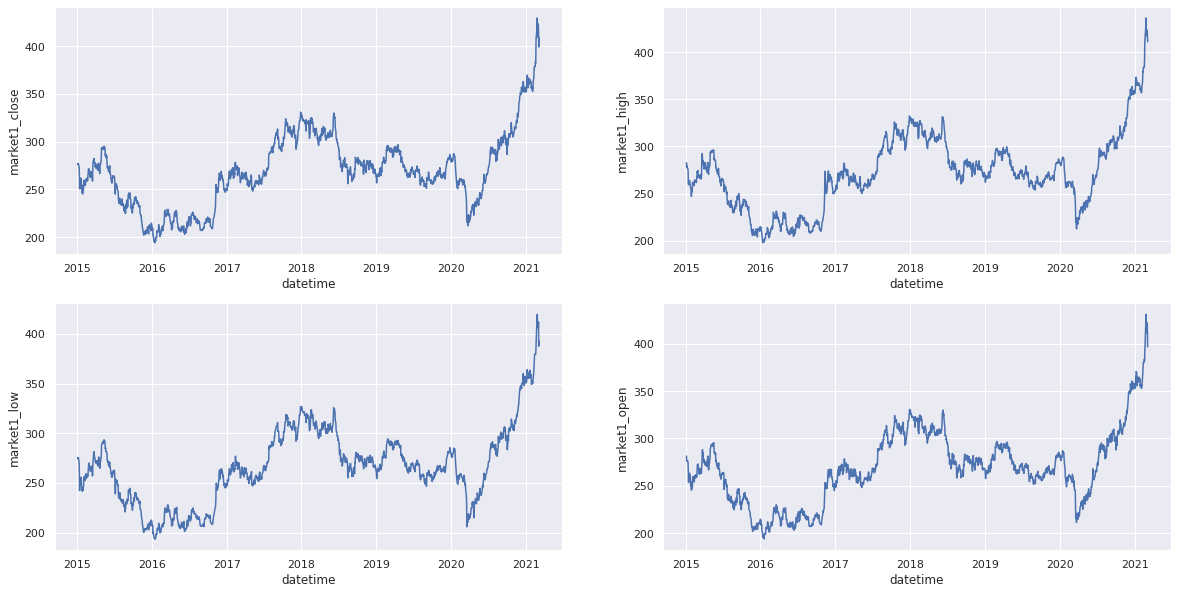

In [532]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))

sns.lineplot(data = df, x='datetime', y='market1_close' , ax=axs[0, 0])
sns.lineplot(data = df, x='datetime', y="market1_high", ax=axs[0, 1])
sns.lineplot(data = df, x='datetime', y="market1_low", ax=axs[1, 0])
sns.lineplot(data = df, x='datetime', y="market1_open", ax=axs[1, 1])

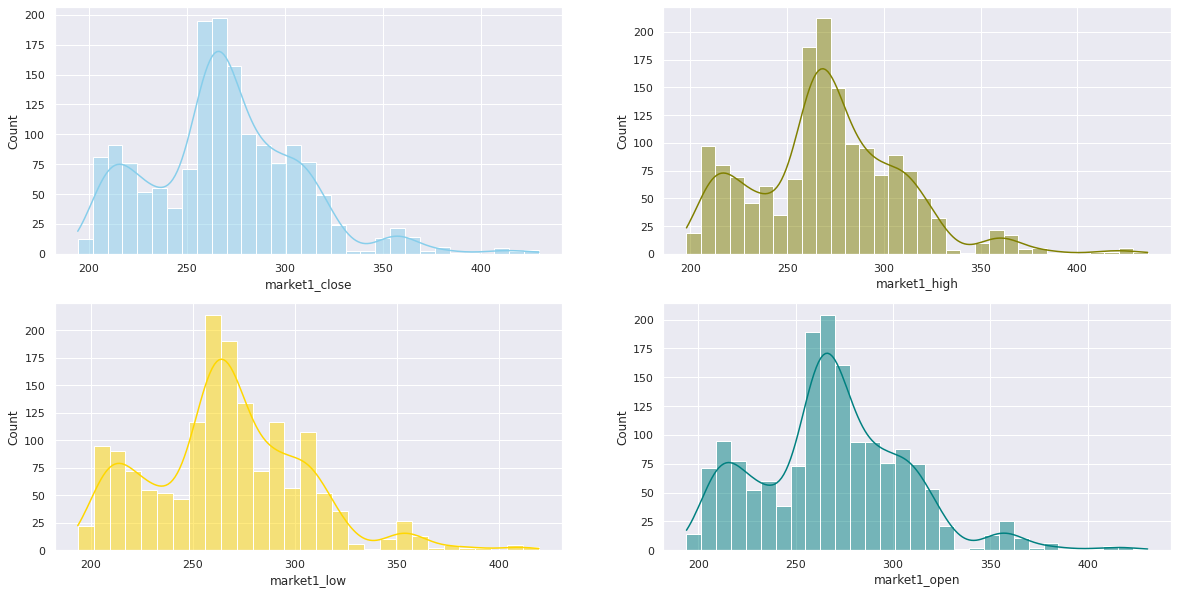

In [533]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))

sns.histplot(data=df, x="market1_close", kde=True, color="skyblue", ax=axs[0, 0])
sns.histplot(data=df, x="market1_high", kde=True, color="olive", ax=axs[0, 1])
sns.histplot(data=df, x="market1_low", kde=True, color="gold", ax=axs[1, 0])
sns.histplot(data=df, x="market1_open", kde=True, color="teal", ax=axs[1, 1])

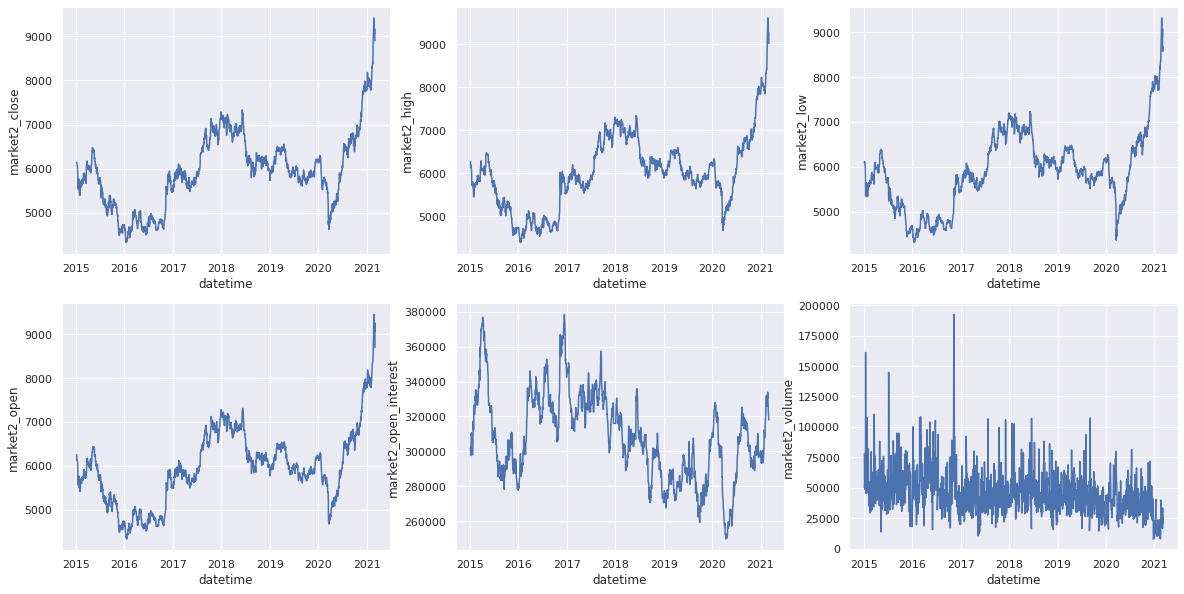

In [534]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))

sns.lineplot(data = df, x='datetime', y='market2_close' , ax=axs[0, 0])
sns.lineplot(data = df, x='datetime', y="market2_high", ax=axs[0, 1])
sns.lineplot(data = df, x='datetime', y="market2_low", ax=axs[0,2])
sns.lineplot(data = df, x='datetime', y="market2_open", ax=axs[1, 0])
sns.lineplot(data = df, x='datetime', y="market2_open_interest", ax=axs[1,1])
sns.lineplot(data = df, x='datetime', y="market2_volume", ax=axs[1, 2])

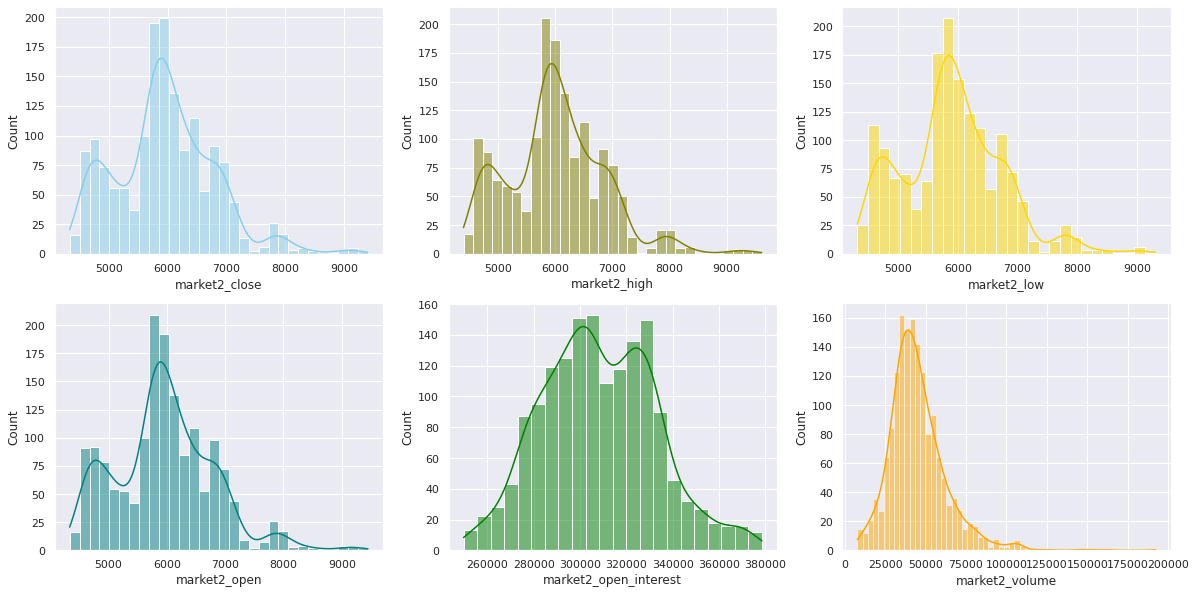

In [535]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))

sns.histplot(data=df, x="market2_close", kde=True, color="skyblue", ax=axs[0, 0])
sns.histplot(data=df, x="market2_high", kde=True, color="olive", ax=axs[0, 1])
sns.histplot(data=df, x="market2_low", kde=True, color="gold", ax=axs[0, 2])
sns.histplot(data=df, x="market2_open", kde=True, color="teal", ax=axs[1, 0])
sns.histplot(data=df, x="market2_open_interest", kde=True, color="green", ax=axs[1, 1])
sns.histplot(data=df, x="market2_volume", kde=True, color="orange", ax=axs[1, 2])

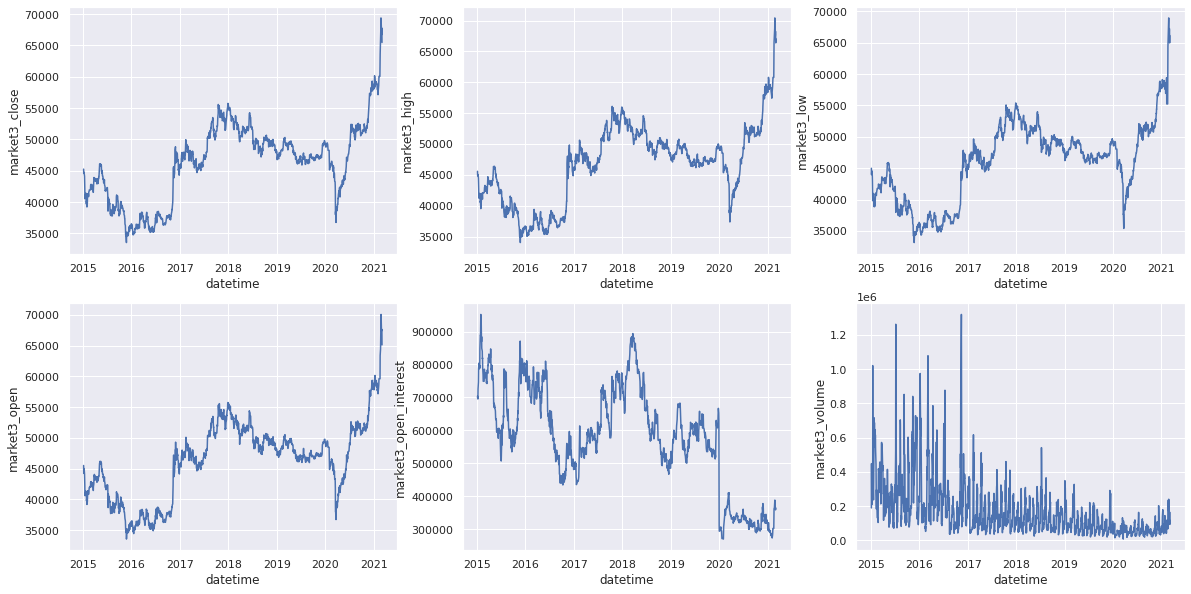

In [536]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))

sns.lineplot(data = df, x='datetime', y='market3_close' , ax=axs[0, 0])
sns.lineplot(data = df, x='datetime', y="market3_high", ax=axs[0, 1])
sns.lineplot(data = df, x='datetime', y="market3_low", ax=axs[0,2])
sns.lineplot(data = df, x='datetime', y="market3_open", ax=axs[1, 0])
sns.lineplot(data = df, x='datetime', y="market3_open_interest", ax=axs[1,1])
sns.lineplot(data = df, x='datetime', y="market3_volume", ax=axs[1, 2])

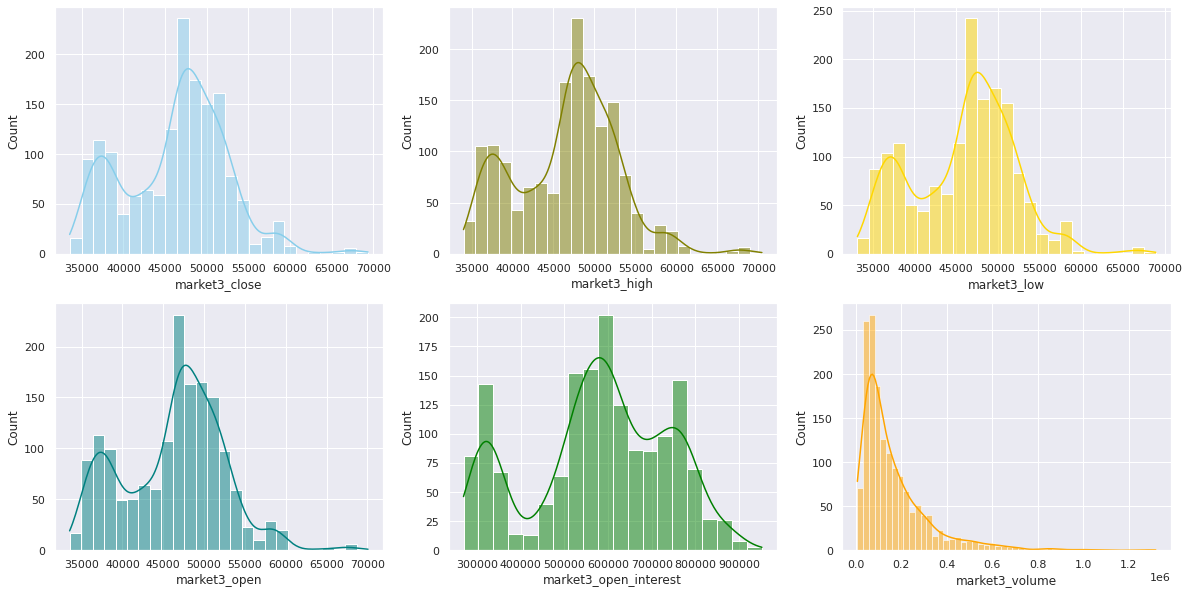

In [537]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))

sns.histplot(data=df, x="market3_close", kde=True, color="skyblue", ax=axs[0, 0])
sns.histplot(data=df, x="market3_high", kde=True, color="olive", ax=axs[0, 1])
sns.histplot(data=df, x="market3_low", kde=True, color="gold", ax=axs[0, 2])
sns.histplot(data=df, x="market3_open", kde=True, color="teal", ax=axs[1, 0])
sns.histplot(data=df, x="market3_open_interest", kde=True, color="green", ax=axs[1, 1])
sns.histplot(data=df, x="market3_volume", kde=True, color="orange", ax=axs[1, 2])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


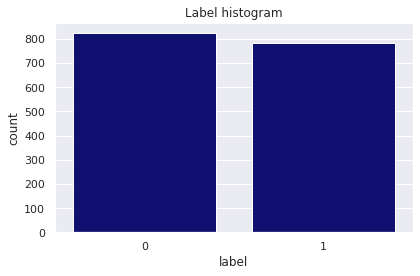

In [538]:
fig, ax = plt.subplots()
sns.countplot(df['label'], color='navy')

ax.set_xlabel('label')
ax.set_ylabel('count')
ax.set_title(r'Label histogram')

fig.tight_layout()
plt.show()

In [539]:
Counter(df['label'])

Counter({0: 825, 1: 781})

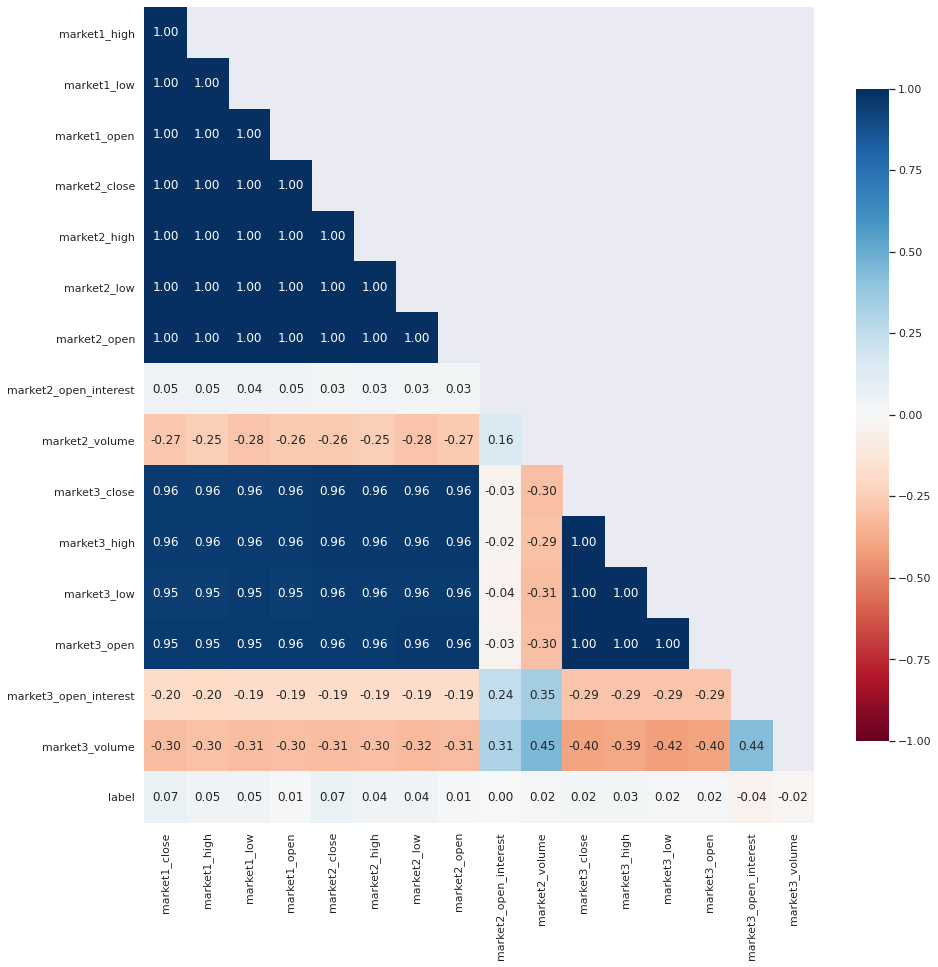

In [540]:
# correlation
# dropping label, since it's a categorical feature
df_corr = df.iloc[:, :-1].corr()

fig, ax = plt.subplots(figsize=(15, 15))
# mask to get only bottom half
mask = np.triu(df_corr)

# adjust mask and df for better visualization
mask = mask[1:, :-1]
corr = df_corr.iloc[1:,:-1].copy()

# plot heatmap
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='RdBu',
           vmin=-1, vmax=1, cbar_kws={"shrink": .8})
# yticks
plt.yticks(rotation=0)
plt.show()

The correlation matrix indicates a strength of linear dependance between features. Features used for modelling should be highly correlated with the label, but not overly correlated with each other. 

Looking at descriptive statistics, histograms, line plots and the correlation matrix, I can tell that high, low, open and close prices for each of the markets are behaving in a similar way, they are almost on the same level and thus, they are perfectly correlated. Therefore if they need to be taken into account for the analysis, only one of the price value will be used. 

Furthermore, the price for all 3 markets are highly correlated - at a 95-96% level, which would indicate that not all of them should be used in modelling, as they don't bring additional information. 

The interest and volume are not correlated with the prices and each other so there's nothing stopping me from using them as features in modelling.  



In [541]:
# correlation beteen categorical and continuous features
for col in df.columns[1:-2]:
    pbc = pointbiserialr(df[col], df['label'])
    print("Feature:", col, "\n", pbc)

Feature: market1_high 
 PointbiserialrResult(correlation=0.04614986588199242, pvalue=0.06445813026371026)
Feature: market1_low 
 PointbiserialrResult(correlation=0.04548556018075197, pvalue=0.06840120460844747)
Feature: market1_open 
 PointbiserialrResult(correlation=0.014238899327518388, pvalue=0.5685369674045347)
Feature: market2_close 
 PointbiserialrResult(correlation=0.06586958282916845, pvalue=0.00827760813556816)
Feature: market2_high 
 PointbiserialrResult(correlation=0.041646320249977914, pvalue=0.09523680266186119)
Feature: market2_low 
 PointbiserialrResult(correlation=0.04138987518431677, pvalue=0.09729417692357213)
Feature: market2_open 
 PointbiserialrResult(correlation=0.00985640656392285, pvalue=0.6930666342468366)
Feature: market2_open_interest 
 PointbiserialrResult(correlation=0.001629633057770596, pvalue=0.9479696771507987)
Feature: market2_volume 
 PointbiserialrResult(correlation=0.016426630790467578, pvalue=0.5106487230905205)
Feature: market3_close 
 Pointbiseri

Given a significance level of 0.05, there is a significant correlation between the label and all prices for all three markets. However, the strength of correlation is very low, which means that there is not really a linear dependance between the label and Markets' price levels. 

# Feature engineering

In [542]:
label = df['label']

features = df[['market1_open', 'market2_open', 'market3_open', 
               'market2_open_interest', 'market3_open_interest', 
               'market2_volume', 'market3_volume']]

In [543]:
# 3 days moving variance
vars = features.rolling(window=3).var()
vars = vars.fillna(method='bfill')
vars.columns = [col+"_rollvar" for col in vars.columns]
features = features.join(vars)

In [544]:
features.head()

,market1_open,market2_open,market3_open,market2_open_interest,market3_open_interest,market2_volume,market3_volume,market1_open_rollvar,market2_open_rollvar,market3_open_rollvar,market2_open_interest_rollvar,market3_open_interest_rollvar,market2_volume_rollvar,market3_volume_rollvar
1,281.40,6255.0,45500.0,301759.0,704092.0,78077.0,189194.0,8.310833,4508.333333,431433.333333,4.361884e+06,8.059809e+06,235518427.0,1.674352e+10
2,276.95,6150.0,44210.0,299683.0,698540.0,50088.0,447986.0,8.310833,4508.333333,431433.333333,4.361884e+06,8.059809e+06,235518427.0,1.674352e+10
3,276.00,6130.0,44640.0,297582.0,700286.0,53173.0,317816.0,8.310833,4508.333333,431433.333333,4.361884e+06,8.059809e+06,235518427.0,1.674352e+10
4,276.40,6126.5,44650.0,300723.0,695008.0,55424.0,208524.0,0.227500,160.750000,63100.000000,2.560280e+06,7.230137e+06,7176187.0,1.437184e+10
5,276.70,6132.0,45000.0,303841.0,725376.0,48765.0,384066.0,0.123333,7.750000,42033.333333,9.793814e+06,2.632635e+08,11473291.0,7.858133e+09


# Modelling

In [438]:
# last 50 days is the test set
X_train = features.iloc[:-50, :]
y_train = label[:-50]

X_test = features.iloc[-50:, :]
y_test = label[-50:]

In [408]:
model = LogisticRegression(random_state=42)

In [409]:
model.fit(X_train, y_train)
y_true, y_pred = y_test, model.predict(X_test)

ValueError: ignored